In [1]:
%load_ext rpy2.ipython

In [2]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from pathlib import Path
pandas2ri.activate()

In [3]:
%%R
#install.packages("BiocManager")
#BiocManager::install("DESeq2", update=FALSE, ask=FALSE)
#BiocManager::install("limma", update=FALSE, ask=FALSE)
#BiocManager::install("lumi", update=FALSE, ask=FALSE)
#BiocManager::install("qvalue", update=FALSE, ask=FALSE)


NULL


### Initialization of Study 1 dataset
First, we will use our existing methods in R to read in our dataset from the first study and split it into healthy and controls as separate dataframes which we will hand off those dataframes to our Python code for further analysis. 
We then will select the top 25 genes based on the mean expression values in our glaucoma group. We further will adjust these in a separate list by subtracting the mean expression values of the control group to prioritize those which are not expressed in the control group.

In [4]:
%%R 
library("readxl")
library("dplyr")
library("MASS")
library("lumi")
library("limma")
library("broom")
library("qvalue")
dataset <- "GLA02"
controls <- c("Anti-human IgG", "EBNA1", "Bare-bead", "His6ABP")
for (file in list.files(file.path("scripts", "backend"))) {
  source(file.path("scripts", "backend", file))
}


### Pipeline
import(dataset)
stage_1(I01_Import, "P01_Preprocessed")
stage_2(P01_Preprocessed, "P02_Merged")
stage_3(P02_Merged, "P03_Transformed")
full_dataset = P02_Merged$Set_3

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘MASS’


R[write to console]: The following object is masked from ‘package:dplyr’:

    select


R[write to console]: Loading required package: Biobase

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq

In [5]:
%%R -o nameslist
antigen_names = colnames(full_dataset[-1:-2])
gene_names = replace_antigen_names(antigen_names)
nameslist = list("antigen_names" = antigen_names, "gene_names" = gene_names)

This next code block is just an extension of the previous one, separated for ease of reading.

In [6]:
%%R -o top_50 -o adj_top_50
healthy_dataset <- full_dataset[full_dataset$group == 0, ]
gc_dataset <- full_dataset[full_dataset$group == 1, ]
gc_averages <- colMeans(gc_dataset[-1:-2])
hc_averages <- colMeans(healthy_dataset[-1:-2])
adjusted_gc_averages <- gc_averages - hc_averages
gc_averages <- gc_averages[order(gc_averages, decreasing = TRUE)]
adjusted_gc_averages <- adjusted_gc_averages[order(adjusted_gc_averages, decreasing = TRUE)]

top_50 <- names(gc_averages)[1:50]
adj_top_50 <- names(adjusted_gc_averages)[1:50]

#check how many of the top 25 expressed genes are in the adjusted top 25 expressed genes
overlap = sum(top_50 %in% adj_top_50)
print(paste("There are", overlap, "antigens in the top 50 expressed antigens that are also in the top 50 adjusted antigens"))

[1] "There are 14 antigens in the top 50 expressed antigens that are also in the top 50 adjusted antigens"


### Correlated Genes
We will also check our glaucoma dataset from our first study for any genes which were strongly correlated with any of our significant seven genes. For this we will use the Pearson correlation coefficient and select those genes which have a correlation coefficient of greater than 0.75 with any of our significant genes. 


In [7]:
%%R -o correlated_antigens
gc_corr_dataset <- P03_Transformed$Set_3
gc_corr_dataset <- gc_corr_dataset[gc_corr_dataset$group == 1, ]
significant_antigens <- c("HPRA034083", "HPRA000767", "HPRA019035", "HPRA006876", "HPRA003490", "HPRA022019", "HPRA017192")

correlation_threshold <- 0.75
# Revised function to ensure names are preserved in the strong correlations vector
calculate_and_filter_correlations <- function(gc_dataset, significant_antigens, corr_threshold = correlation_threshold) {
  # Filter out non-antigen columns (keep only antigen data)
  antigen_data <- gc_dataset[ , !(names(gc_dataset) %in% c("Internal.LIMS.ID", "group"))]
  
  # Initialize a list to store strong correlation results
  strong_correlation_results_fixed <- list()
  
  # Calculate the full correlation matrix once
  full_correlations <- cor(antigen_data, use = "complete.obs", method = "pearson")
  
  # Iterate over each significant antigen
  for(significant_antigen in significant_antigens) {
    if(significant_antigen %in% names(antigen_data)) {
      # Extract correlations for the current significant antigen
      current_correlations <- full_correlations[, significant_antigen]
      # Ensure names are preserved
      names(current_correlations) <- rownames(full_correlations)
      # Filter for strong correlations (absolute value greater than the threshold)
      strong_correlations <- current_correlations[abs(current_correlations) > correlation_threshold]  
      # Remove the correlation of the antigen with itself, ensuring names are used for filtering
      strong_correlations <- strong_correlations[names(strong_correlations) != significant_antigen]
      
      # Store the strong correlations in the list with the antigen name as the key
      strong_correlation_results_fixed[[significant_antigen]] <- strong_correlations
    } else {
      cat(paste("Warning: Antigen", significant_antigen, "not found in dataset.\n"))
    }
  }
  
  return(strong_correlation_results_fixed)
}
correlation_dataframe <- calculate_and_filter_correlations(gc_corr_dataset, significant_antigens)
# Initialize an empty vector to store all unique antigen names
all_strongly_correlated_antigens <- c()
# Iterate over the list of strong correlations for each significant antigen
for(significant_antigen in names(correlation_dataframe)) {
  # Extract names of strongly correlated antigens for the current significant antigen
  current_antigens <- names(correlation_dataframe[[significant_antigen]])
  
  # Combine with the existing list of antigen names
  all_strongly_correlated_antigens <- c(all_strongly_correlated_antigens, current_antigens)
}
# Remove duplicates to get a unique list of antigen names
all_strongly_correlated_antigens <- unique(all_strongly_correlated_antigens)
# now replace the names with the corresponding genes and save to a list for export to python
correlated_antigens <- all_strongly_correlated_antigens


This part just confirms that there are not outliers in the correlation dataset.

R[write to console]: 
Attaching package: ‘patchwork’


R[write to console]: The following object is masked from ‘package:MASS’:

    area




`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


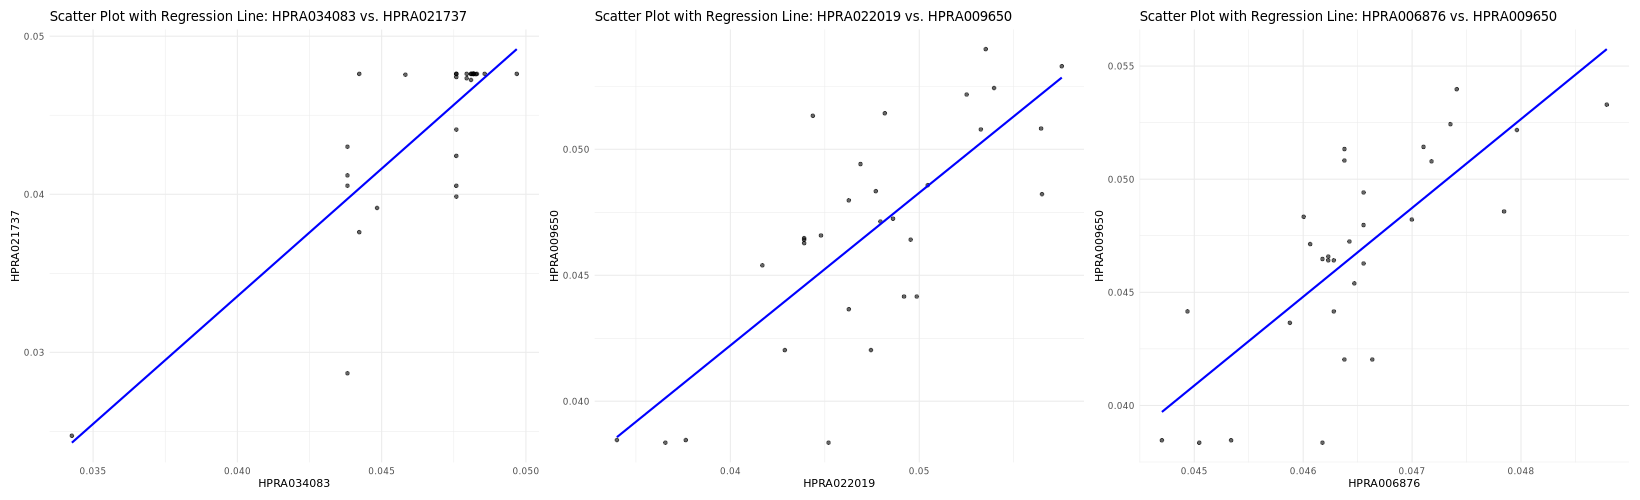

In [8]:
%%R -w 1640 -h 500
library(dplyr)
library(patchwork)
library(ggplot2)
# Initialize an empty list to store pairs
pairs_list <- list()

# Loop through each list in the correlation_dataframe
for (antigen in names(correlation_dataframe)) {
    # Get the vector of correlations for the current antigen
    correlations <- correlation_dataframe[[antigen]]
    # Loop through each item in the vector
    for (correlated_antigen in names(correlations)) {
        # Append the pair (antigen, correlated_antigen) to the pairs_list
        pairs_list <- append(pairs_list, list(c(antigen, correlated_antigen)))
    }
}
# Now let's convert the list to a dataframe for easy handling
pairs_df <- do.call(rbind, lapply(pairs_list, function(x) {
    data.frame(antigen1 = x[1], antigen2 = x[2], stringsAsFactors = FALSE)
}))

# Sample 3 random rows (pairs)
set.seed(123) # Setting a seed for reproducibility
random_pairs <- pairs_df[sample(nrow(pairs_df), 3), ]
# Assuming gc_corr_dataset is a data frame with columns for each antigen
# Generate scatter plots for the 3 random pairs
# Store the plots in a list
plot_list <- list()

for (i in 1:nrow(random_pairs)) {
    pair <- random_pairs[i, ]
    plot_data <- data.frame(
        Antigen1 = gc_corr_dataset[[pair$antigen1]],
        Antigen2 = gc_corr_dataset[[pair$antigen2]]
    )

    p <- ggplot(plot_data, aes(x = Antigen1, y = Antigen2)) +
        geom_point(alpha = 0.6) +
        geom_smooth(method = "lm", se = FALSE, color = "blue") +
        labs(
            title = paste("Scatter Plot with Regression Line:", pair$antigen1, "vs.", pair$antigen2),
            x = pair$antigen1,
            y = pair$antigen2
        ) +
        theme_minimal()

    plot_list[[i]] <- p
}

# Combine the plots side by side
combined_plot <- plot_list[[1]] + plot_list[[2]] + plot_list[[3]] + 
                 plot_layout(ncol = 3)
# Print the combined plot
print(combined_plot)

### Filtering and Ordering
We then will have five lists:
1. The seven genes which were significant in the limma testing after adjusting for multiple testing
2. The top 50 genes based on the p-values from limma testing
3. The top 50 genes based on the mean expression values in the glaucoma group
4. The top 50 genes based on the mean expression values in the glaucoma group, adjusted by the mean expression values in the control group
5. The genes which are correlated with any of the seven significant genes

We will then prioritize as follows:
1. Genes which are significant in the limma testing after adjusting for multiple testing
2. Genes which are significant in the limma testing and in the top expression values
3. Genes which are strongly correlated with any of the seven significant genes
3. Genes which are in the top expression values, and adjusted for the control group, sorted by the adjusted mean expression values
4. Genes which are in the top expression values, sorted by the mean expression values

In [9]:
import pandas as pd
def read_list(file):
    with open(file, 'r') as f:
        return f.read().splitlines()
#top_list = read_list(Path("data", "antigen_selection", 'top_60.list'))
limma_results = pd.read_excel(Path("data", "antigen_selection", 'report.xlsx'))
p_val_top_50 = list(limma_results['Antigen_Names'][:50])
significant_seven = list(limma_results['Antigen_Names'][:7])
for item in p_val_top_50.copy():
    if item in significant_seven:
        p_val_top_50.remove(item)

In [10]:
expression_top = []
top_50 = list(top_50)
adj_top_50 = list(adj_top_50)
#first remove the significant seven
for item in top_50.copy():
    if item in significant_seven:
        top_50.remove(item)
for item in top_50.copy():
    if item in p_val_top_50:
        expression_top.append(item)
        top_50.remove(item)
    elif item in adj_top_50:
        expression_top.append(item)
        top_50.remove(item)
expression_top.extend(top_50)

#we will also make sure we remove the significant seven from the correlated antigens
for item in correlated_antigens.copy():
    if item in significant_seven:
        correlated_antigens.remove(item)

In [11]:
#step 1 - organize our three sources into dictionaries
from rpy2.robjects import r, StrVector
from rpy2.robjects.packages import importr
def replace_antigen_names(antigens):   
    r_vector = StrVector(antigens)
    r.source("scripts/backend/data_handling.R")
    r_result = r.replace_antigen_names(r_vector)
    gene_names = list(r_result)
    return gene_names

p_val_top = {
    "name": "p_val",
    "antigens": list(p_val_top_50),
    "genes": replace_antigen_names(list(p_val_top_50))
    }
exp_top = {
    "name": "expression",
    "antigens": expression_top,
    "genes": replace_antigen_names(expression_top)
    }
adj_top = {
    "name": "adjusted",
    "antigens": list(adj_top_50),
    "genes": replace_antigen_names(list(adj_top_50))
}
corr_top = {
    "name": "correlation",
    "antigens": list(correlated_antigens),
    "genes": replace_antigen_names(list(correlated_antigens))
    }


In [12]:
def discover_highlights(dictionary_list):
    highlight_list = []
    for dictionary in dictionary_list:
        for idx, gene in enumerate(dictionary["genes"]):
            #flatten the gene entry into a list
            genes = gene.split(",")
            for gene in genes:
                highlight_entry = {
                    "origin" : dictionary["name"],
                    "antigen" : dictionary["antigens"][idx],
                    "gene" : gene
                }
                highlight_list.append(highlight_entry)
   
    #get all the genes from the highlights
    gene_list = set([highlight["gene"] for highlight in highlight_list])
    antigen_highlights = []
    for gene in gene_list:
        #if the gene appears in three different sources, it is a highlight
        highlights = [highlight for highlight in highlight_list if highlight["gene"] == gene]
        sources = [highlight["origin"] for highlight in highlights]
        if len(set(sources)) >= 3:
            #add any antigens that correspond to the gene from the highlights list
            antigens = [highlight["antigen"] for highlight in highlights if highlight["gene"] == gene]
            antigen_highlights.extend(antigens)
    antigen_highlights = list(set(antigen_highlights))

    return antigen_highlights

consensus_highlights = discover_highlights([p_val_top, exp_top, adj_top, corr_top])
consensus_highlights_genes = set(replace_antigen_names(consensus_highlights))

#remove consensus highlights from other lists
for dictionary in [p_val_top, exp_top, corr_top]:
    for idx, analyte in enumerate(dictionary["antigens"]):
        #print(dictionary["name"], idx, analyte)
        if analyte in consensus_highlights:
            dictionary["antigens"].remove(analyte)
            dictionary["genes"].remove(dictionary["genes"][idx])
# def expand_list_items(names_list):
#     # Split apart multiples into sublists and flatten the sublists
#     flattened_list = [item.strip() for sublist in names_list for item in sublist.split(",")]
    
#     # Use a dict to remove duplicates while maintaining order
#     unique_items = dict.fromkeys(flattened_list)
    
#     # Convert the keys of the dictionary back into a list
#     top_list_ordered_unique = list(unique_items.keys())
#     return top_list_ordered_unique


# # r_vector = StrVector(expression_top)
# # r.source("scripts/backend/data_handling.R")
# # r_result = r.replace_antigen_names(r_vector)

# # python_result = list(r_result)
# check_highlights([p_val_top, expression_top, correlation_top])


In [13]:
def expand_list_items(top_list):
    # Split apart multiples into sublists and flatten the sublists
    flattened_list = [item.strip() for sublist in top_list for item in sublist.split(",")]
    
    # Use a dict to remove duplicates while maintaining order
    unique_items = dict.fromkeys(flattened_list)
    
    # Convert the keys of the dictionary back into a list
    top_list_ordered_unique = list(unique_items.keys())
    return top_list_ordered_unique

In [14]:
# def read_list(file):
#     with open(file, 'r') as f:
#         return f.read().splitlines()
# top_list = read_list(Path("data", "antigen_selection", 'top_60.list'))
# significant_seven = ["DGCR2", "LOX", "FUT2", "LGSN", "ANXA10", "TMEM9B", "CDH5"]
# #remove the significant seven from the top_list
# top_list = [x for x in top_list if x not in significant_seven]
# p_val_top_50 = top_list[:50]
# #some of the items in this list are actually multiple genes, so we need to fix that


# p_val_top_50 = expand_list_items(p_val_top_50)
# expression_val_top_50 = expand_list_items(list(top_50).copy())
# adjusted_top_50 = expand_list_items(list(adj_top_50).copy())
# correlated_gene_list = expand_list_items(correlated_genes.copy())
# combined_list =[]
# #remove the significant seven from the expression_val_top_50
# expression_val_top_50 = [x for x in expression_val_top_50 if x not in significant_seven]
# #remove the significant seven from the adjusted_top_50
# adjusted_top_50 = [x for x in adjusted_top_50 if x not in significant_seven]
# #check if any items appear in exp_top_50 and p_top_50 and adjusted_top_50
# highlight_list = list((set(expression_val_top_50) & set(p_val_top_50) & set(adjusted_top_50)))
# # highlight_list = []
# for item in highlight_list:
#     expression_val_top_50.remove(item)
#     p_val_top_50.remove(item)
#     adjusted_top_50.remove(item)

# #In order to prioritize the items which appear in two metrics over the items which appear in one metric, we will do some list sorting
# #First we will sort the items which appear in two metrics
# p_e, a_e = [], []
# for item in expression_val_top_50:
#     if item in p_val_top_50:
#         p_e.append(item)
#         p_val_top_50.remove(item)
#         expression_val_top_50.remove(item)
#     elif item in adjusted_top_50:
#         a_e.append(item)
#         adjusted_top_50.remove(item)
#         expression_val_top_50.remove(item)
# #Then we will compile our expression list as a "zipper" of the two lists, followed by anything remaining in the expression_val_top_50 list (which only appears in one metric)
# #Note that appearing in p_val_top_50 is prioritized over appearing in adjusted_top_50, but only by one index position in our final list
# expression_list = []
# for i in range(max(len(p_e), len(a_e))):
#     if i < len(p_e):
#         expression_list.append(p_e[i])
#     if i < len(a_e):
#         expression_list.append(a_e[i])

# expression_list += expression_val_top_50

# #Finally, since our correlation genes are lower priority than the highlight list, but higher priority than the expression list, we will remove them acccording to the same logic
# for item in highlight_list:
#     if item in correlated_gene_list:
#         correlated_gene_list.remove(item)
# for item in correlated_gene_list:
#     if item in p_val_top_50:
#         p_val_top_50.remove(item)
#     elif item in expression_list:
#         expression_list.remove(item)
# print(set(expression_list) & set(p_val_top_50))
# ##For some reason SGK494 wants to overlap in our sets so we are just gonna remove it from the expression list
# expression_list.remove("SGK494")
# print(set(expression_list) & set(p_val_top_50))

### Result 
These two we definitely want because every metric we use here identifies these in the top

In [15]:
consensus_highlights 

['HPRA022890',
 'HPRA024016',
 'HPRA022891',
 'HPRA042866',
 'HPRA045993',
 'HPRA020522',
 'HPRA021736',
 'HPRA046255',
 'HPRA019334',
 'HPRA020521',
 'HPRA013060',
 'HPRA022506',
 'HPRA019333',
 'HPRA013851',
 'HPRA013573',
 'HPRA042751',
 'HPRA017982',
 'HPRA021737',
 'HPRA045372',
 'HPRA029223',
 'HPRA001197',
 'HPRA004387',
 'HPRA002363',
 'HPRA026116',
 'HPRA011757',
 'HPRA037260']

## Summary of Lists
Now we have three lists containing:
1. The genes which were highlighted by all metrics
2. The genes which were highly correlated with the significant genes
3. The genes which were highlighted by the top expression values
4. The genes which were highlighted by the top p values

All of these list are ordered by their respective values, so we can easily drop from the end of the list based on the number of genes we want to keep. 

We actually have two more things to add to this set of lists.

5. Genes which are interesting based on other studies, but not necessarily in our lists
6. Genes which are highlighted by network analysis using our graphnet package

After that, we can adjust the number of genes we keep from numbers 2,3, and 5 here. Numbers 1 and 4 will be kept in their entirety.

In [16]:
#These genes are highlighted by the corresponding journals for their connection with xfg
other_studies_dictionary = {
    "CACNA1A": "https://journals.lww.com/glaucomajournal/fulltext/2018/07001/mechanisms_of_glaucoma_in_exfoliation_syndrome.17.aspx",
    "AGPAT1": "https://pubmed.ncbi.nlm.nih.gov/31687947/",
    "CYP39A1": "https://pubmed.ncbi.nlm.nih.gov/34763023/",
    "POMP": "https://www.nature.com/articles/ng.3875",
    "TMEM136": "https://www.nature.com/articles/ng.3875",
    "RBMS3": "https://www.nature.com/articles/ng.3875",
    "SEMA6A": "https://www.nature.com/articles/ng.3875",
    "LOXL1": "addurllater",
}
#We will double check that these genes do not appear in any of the lists, if they do, they can be removed from the dictionary
for gene in other_studies_dictionary.keys():
    if gene in expand_list_items(exp_top['genes']) or gene in expand_list_items(p_val_top['genes']) or gene in expand_list_items(corr_top['genes']):
        print(f"{gene} appears in one of the lists")
        other_studies_dictionary.pop(gene)

# Network Interaction

### Determining counts
Before we start the interaction analysis, we need to know how many we will keep from each list.
We know that we will keep all of the significant seven, and all of the other studies genes.
We also will definitely keep the genes that are in our consensus highlights.
We have 92 total to choose, so lets work from there.
We will choose a ratio of 40% from the network interaction list, and 60% from the other lists, divided evenly among metrics.

In [17]:
ratio = [0.40, 0.20, 0.2, .2]
reserved_count = len(significant_seven) + len(other_studies_dictionary) + len(consensus_highlights) 
remaining_count = 92 - reserved_count

#now we can multiply each ratio by the remaining count to get the number of genes we will choose from each list
network_interaction_count = int(remaining_count * ratio[0])
expression_count = int(remaining_count * ratio[1])
p_value_count = int(remaining_count * ratio[2])
correlation_count = int(remaining_count * ratio[3])
#if the sum of these counts is less than the remaining count, we will add the difference to the network interaction count
difference = remaining_count - (network_interaction_count + expression_count + p_value_count + correlation_count)
#distribute any difference evenly across the lists
for i in range(difference):
    if i % 4 == 0:
        network_interaction_count += 1
    elif i % 4 == 1:
        expression_count += 1
    elif i % 4 == 2:
        p_value_count += 1
    else:
        correlation_count += 1

print(f"We will choose {network_interaction_count} genes from the network interaction list, {expression_count} genes from the expression list, {p_value_count} genes from the p_value list, and {correlation_count} genes from the correlation list")

We will choose 21 genes from the network interaction list, 10 genes from the expression list, 10 genes from the p_value list, and 10 genes from the correlation list


In [18]:
import json
import time
import collections
import pandas as pd
from pathlib import Path
from modules import Graphnet

keychain = Path("keys", ".keychain")
keys = json.load(open(keychain))
graph = Graphnet(
    uri=keys["graphnet"]["uri"],
    username=keys["graphnet"]["username"],
    password=keys["graphnet"]["password"],
)
#Now we will set our limits for the number of genes we will choose from each list
expression_aggregate = expand_list_items(exp_top['genes'])
p_value_aggregate = expand_list_items(p_val_top['genes'])
correlation_aggregate = expand_list_items(corr_top['genes'])
s7_aggregate = set(replace_antigen_names(significant_seven))
highlight_aggregate = set(replace_antigen_names(consensus_highlights))

# #Then we will join all of the items we are keeping, except the other studies genes, into one list for use by our network interaction model
aggregate_top_list = []
aggregate_top_list.extend(s7_aggregate)
aggregate_top_list.extend(highlight_aggregate)
iteration = max(len(expression_aggregate), len(p_value_aggregate), len(correlation_aggregate))
for i in range(iteration):
    if i < len(expression_aggregate):
        aggregate_top_list.append(expression_aggregate[i])
    if i < len(p_value_aggregate):
        aggregate_top_list.append(p_value_aggregate[i])
    if i < len(correlation_aggregate):
        aggregate_top_list.append(correlation_aggregate[i])
aggregate_top_list = expand_list_items(aggregate_top_list)[0:50]
# aggregate_top_list.extend(significant_seven)
# aggregate_top_list.extend(highlight_list)
# aggregate_top_list.extend(correlated_gene_list)
# current_length = len(aggregate_top_list)
# target_length = 92 - (len(other_studies_dictionary) + network_interaction_count)
# #zipper in expression and p_value lists up to 40 items total. This prevents the network interaction list from being too long based on the lower content of our lists
# #subtracted 4 additionally because the numbers are not working out perfectly
# for i in range(0, int((target_length-current_length)/2)-4):
#     #print(i)
#     if i < len(expression_list):
#         aggregate_top_list.append(expression_list[i])
#     if i < len(p_value_list):
#         aggregate_top_list.append(p_value_list[i])


#Just to double check, we should expect a length of 92 - (the length of the other studies dictionary+the length of the planned network interaction list)
# print(len(aggregate_top_list) == 92 - (len(other_studies_dictionary) + network_interaction_count) )   #True

## Building Interaction Dictionaries for Nodes

In this analysis, we aim to explore the interactions between a set of proteins. For each protein (or "node") in our list of interest (`aggregate_top_list`), we construct an interaction dictionary. This dictionary maps out the shortest paths between the start node and each node of interest, highlighting the key proteins (or "intermediates") involved. Particularly, we focus on identifying proteins that appear across multiple paths, referred to as "prime_duplicates." These prime duplicates may suggest significant roles in protein interaction networks.

### Function Overview

The core of our analysis relies on the `build_interaction_dictionary` function. This function generates a dictionary of proteins along the shortest paths between a start node and nodes of interest, using our graph network based on Neo4j.


This function processes a given start node against a list of nodes of interest, identifying all relevant proteins along the shortest paths between those nodes and pinpointing any significant overlaps as prime duplicates.

In [19]:
def build_interaction_dictionary(start_node:str, nodes_of_interest:list):

    """
    This function takes a start node and a list of nodes of interest and returns a dictionary of the proteins appearing along the shortest paths between the start node and each node of interest.
    Additionally, identifies any proteins that appear in multiple paths as "prime_duplicates"

    Args:
    start_node: The protein_ID of the start node
    nodes_of_interest: A list of protein_IDs of the nodes of interest

    Returns:
    node_dict: A dictionary containing the start node, the intermediate interactions, and any prime_duplicates

    """
    node_paths_list = []
    for end_node in nodes_of_interest:
        if end_node == start_node:
            continue
        #print(f'Finding path from {start_node} to {end_node}')
        path = graph.find_shortest_path(start_node=start_node, end_node=end_node, min_strength=50)
        actual_path = path[0]["path"]
        path_nodes = [node["protein_ID"] for node in actual_path.nodes]
        #remove the start and end nodes from the list
        path_nodes.remove(start_node)
        path_nodes.remove(end_node)
        #if the path is not empty, print the path
        if path_nodes != []:
            #print(f'Path from {start_node} to {end_node} is {path_nodes}')
            node_paths_list.append(path_nodes)
        #else:
            #print(f'The nodes {start_node} and {end_node} directly interact')
    #flatten the list
    node_paths_list = [item for sublist in node_paths_list for item in sublist]
    #print any duplicates in the list
    prime_duplicates = [item for item, count in collections.Counter(node_paths_list).items() if count > 1]
    node_dict = {
        "node": start_node,
        "intermediate_interactions": node_paths_list,
        "prime_duplicates": prime_duplicates
    }
    return node_dict

## Implementation

First, we need to check that all the items in our `aggregate_top_list` are available in our database and remove any that are unsupported. We will print these out so that we know what has been excluded. We then iterate through each node in `aggregate_top_list`, applying `build_interaction_dictionary` to uncover the network of interactions. The following code snippet demonstrates this process, with a status update displaying the progress of this computation.

Finally we can a quick description of the dataframe just to see that we have results here.

In [20]:
unfound_items = []
for idx, item in enumerate(aggregate_top_list):
    #print(idx, item)
    checklist = (graph.execute_query(f"MATCH (p:protein) WHERE p.protein_ID = '{item}' RETURN p.protein_ID, p.annotation"))
    if checklist:
        pass#print(f"{item} is in the database")
    else:
        print(f"{item} is not in the database")
        #print(f'{idx}, {item} not found')
        unfound_items.append((item, idx))
#remove the unfound items from the list based on the index
for item in unfound_items[::-1]:
    #drop the item from the list
    aggregate_top_list.pop(item[1])  

SGK494 is not in the database
AC005726.1 is not in the database
PALM2-AKAP2 is not in the database
PALM2 is not in the database


In [21]:
interaction_df = pd.DataFrame()
total_nodes = len(aggregate_top_list)
for index, start_node in enumerate(aggregate_top_list):
    percentage_complete = (index + 1) / total_nodes * 100  # Calculate completion percentage
    print(f"Percentage complete: {percentage_complete:.2f}% | Currently processing: {start_node}", end='\r')
    node_dict = build_interaction_dictionary(start_node, aggregate_top_list)
    # Note: It seems there might be a typo in your code `_append` should be `append`
    interaction_df = interaction_df._append(node_dict, ignore_index=True)
    time.sleep(0.1) #added to prevent lockup of the database due to too many requests
print(interaction_df.describe())

       node                          intermediate_interactions  \1
count    46                                                 46   
unique   46                                                 46   
top     LOX  [MFSD2A, HSPB6, MRI1, VEGFB, ACTB, HYOU1, ARPC...   
freq      1                                                  1   

           prime_duplicates  
count                    46  
unique                   45  
top     [HSPB6, CFTR, ARF5]  
freq                      2  


### Looking for overlaps in the interaction dictionaries  

Next we will iterate through our interaction dictionaries and look for overlaps in the proteins that are found in the shortest paths between the start node and the nodes of interest. We will then identify the proteins that are found in the most interaction dictionaries and consider these as potential antigens for the xMAP assay.  

We chose to first select the significant proteins from our previous study which had adjusted p-valuse less than 0.05 and highlight the overlapping proteins in these interaction dictionaries over the rest of the list.

We also note whether any of the proteins in the prime duplicates appear in multiple entries in the top list. This may suggest that these proteins are especially significant and should be considered for the xMAP assay.

#### Clarification on Primes
As a definition, herein we refer to "prime duplicates" as proteins which appear in the shortest path from a given starting node to other nodes within a given subset. These prime duplicates are of particular interest, as they may suggest significant roles in protein interaction networks.

"significant primes" is meant to reflect an added value, such as if these prime duplicates are derived from a starting node from our "significant seven" list, or if they are "prime duplicates" that appear based on multiple starting nodes. Note: this is not a formal term, but rather a way to distinguish between prime duplicates that are of particular interest.

In [22]:
#check the prime_duplicates for the significant seven
significant_primes = []
for node in list(s7_aggregate):
    #print(f"Prime duplicates for {node}: {interaction_df[interaction_df['node'] == node]['prime_duplicates'].values[0]}")
    significant_primes.append(interaction_df[interaction_df['node'] == node]['prime_duplicates'].values[0])
#flatten the list
significant_primes = [item for sublist in significant_primes for item in sublist]
#print any duplicates in the list
multi_sig_primes = [item for item, count in collections.Counter(significant_primes).items() if count > 1]
print("")
print(f"Duplicate prime duplicates: {multi_sig_primes}")
#remove duplicates
significant_primes = list(set(significant_primes))
#double check that none of the significant primes are in the aggregate_top_list
for gene in significant_primes:
    if gene in aggregate_top_list:
        print(f"{gene} is in the aggregate_top_list")
        significant_primes.remove(gene)
print(f"Prime duplicates for the significant seven: {significant_primes}")
#add the multi_sig_primes to the significant_primes
significant_primes.extend(multi_sig_primes)
#remove any duplicates
significant_primes = list(set(significant_primes))
print(f"Total number of significant primes: {len(significant_primes)}")


Duplicate prime duplicates: ['HSPB6', 'CLTC', 'ACTB']
Prime duplicates for the significant seven: ['SOD3', 'CLTC', 'S100A2', 'TMEM59L', 'SOX5', 'HYOU1', 'ENDOV', 'HSPB6', 'PDK4', 'ACTB', 'SERPINH1', 'VCP', 'BBS10', 'CFTR', 'AUP1', 'PHGDH', 'RNF150', 'MAPK8IP3']
Total number of significant primes: 18


### Expanding to the full list

We repeat the process again for the rest of the proteins in the top list with the exception that we also will count the number of times that the proteins in the prime duplicates appear in the interaction dictionaries. This will allow us to select the most likely candidates for the xMAP assay.
Here we exclude any proteins already in the top list from the previous step, and select an "n" value for how many additional proteins we would like to include, which will be the remainder of our network interaction count, minus the number of prime duplicates already discovered.
The printed value shows the protein names as well as the number of starting nodes they appear as prime duplicates for. This will allow us to select the most likely candidates for the xMAP assay.

In [23]:
# Number of top items to print
n = network_interaction_count- len(significant_primes)

secondary_significant_primes = [item for item in interaction_df['prime_duplicates']]
secondary_significant_primes = [item for sublist in secondary_significant_primes for item in sublist]
secondary_multi_sig_primes = [(item,count) for item, count in collections.Counter(secondary_significant_primes).items() if count > 1]
new_additions = [item for item in secondary_multi_sig_primes if item[0] not in significant_primes]
new_additions.sort(key=lambda x: x[1], reverse=True)
#double check that none of the new additions are in the aggregate_top_list or the significant_primes
for prime, count in new_additions:
    if prime in aggregate_top_list or prime in significant_primes:
        print(f"{prime} is in the aggregate_top_list or the significant_primes")
        new_additions.remove((prime, count))

print(f"The top {n} prime duplicates are:")
for prime, count in new_additions[:n]:
    print(f"{prime} : {count}")



The top 3 prime duplicates are:
ARF5 : 9
CTNNB1 : 7
GRIA3 : 4


## Final Answer

Finally, we will combine our lists:
1. The significant proteins from the previous study
2. The proteins that appeared in the most interaction dictionaries based on the significant seven
3. The proteins that appeared in the most interaction dictionaries based on the rest of the top list

In [45]:
new_additions_genes = [n[0] for n in new_additions]
exp_top_genes = expand_list_items(exp_top['genes'])
p_val_top_genes = expand_list_items(p_val_top['genes'])
corr_top_genes = expand_list_items(corr_top['genes'])
other_studies_genes = list(other_studies_dictionary.keys())
significant_primes = list(significant_primes)
final_list_genes = final_list_genes

##I want to build a quick tool that will allow me to check which lists a given gene is in and give me the indexes in those lists
def gene_checker(genecol):
    for gene in genecol:
        for listname, genes_list in {
            "new_additions" : new_additions_genes, 
            "exp_top" : exp_top_genes, 
            "p_val_top": p_val_top_genes, 
            "corr_top": corr_top_genes, 
            # "final_list" : final_list_genes,
            "other_studies" : other_studies_genes,
            "significant_primes" : significant_primes
            }.items():
            if gene in genes_list:
                #find the index of the gene in the list
                index = genes_list.index(gene)
                print(f"{gene} is in {listname} at index {index}")

genecol = ["AGPAT1", "DCUN1D4", "DCUN1D4", "PHGDH", "PHGDH", "TMEM59L", "ENDOV", "POMP", "POMP", "VCP", "VCP", "AUP1", "AUP1", "GAS7", "GAS7", "RBMS3", "ACTB", "ACTB", "CYP39A1", "PDK4", "CACNA1A", "CACNA1A", "HSPB6", "HSPB6", "S100A2", "CFTR", "CFTR", "HYOU1", "SEMA6A", "CLTC", "KIF1A", "KIF1A", "SERPINH1", "CRYAB", "LOXL1", "LOXL1", "SOD3", "CTNNB1", "CTNNB1", "MAPK8IP3", "MAPK8IP3", "SOX5", "BBS10", "GRIA3", "GRIA3", "RNF150"]
gene_checker(genecol)

AGPAT1 is in other_studies at index 1
DCUN1D4 is in new_additions at index 4
DCUN1D4 is in new_additions at index 4
PHGDH is in significant_primes at index 8
PHGDH is in significant_primes at index 8
TMEM59L is in significant_primes at index 3
ENDOV is in significant_primes at index 17
POMP is in other_studies at index 3
POMP is in other_studies at index 3
VCP is in significant_primes at index 11
VCP is in significant_primes at index 11
AUP1 is in significant_primes at index 14
AUP1 is in significant_primes at index 14
GAS7 is in new_additions at index 6
GAS7 is in new_additions at index 6
RBMS3 is in other_studies at index 5
ACTB is in exp_top at index 49
ACTB is in significant_primes at index 15
ACTB is in exp_top at index 49
ACTB is in significant_primes at index 15
CYP39A1 is in other_studies at index 2
PDK4 is in significant_primes at index 7
CACNA1A is in other_studies at index 0
CACNA1A is in other_studies at index 0
HSPB6 is in significant_primes at index 6
HSPB6 is in signific

In [40]:
# Adding it all together now
final_list_antigens = []
final_list_genes = []
#First we add our reserved items
final_list_antigens.extend(significant_seven)
final_list_antigens.extend(consensus_highlights)
final_list_genes.extend(other_studies_dictionary.keys())
#Then we add from each of our metrics the intended amount of items
final_list_antigens.extend(p_val_top['antigens'][0:p_value_count])
final_list_antigens.extend(exp_top['antigens'][0:expression_count])
final_list_antigens.extend(corr_top['antigens'][0:correlation_count])
final_list_genes.extend(significant_primes)
final_list_genes.extend([item[0] for item in new_additions[:n]])

#Now we check the length of the final list, after removing any duplicates
final_list = list(set(final_list_antigens))+list(set(final_list_genes))
print(f"The final list contains {len(final_list)} unique antigens and genes")
addition_length = 92 - len(final_list)
print(f"We will add {addition_length} items evenly from the different metrics")
# Initialize counters
p_count = 0
e_count = 0
c_count = 0
n_count = 0
i=1
while len(set(final_list_antigens)) + len(set(final_list_genes)) < 92:
    final_list_antigens = list(set(final_list_antigens))
    final_list_genes = list(set(final_list_genes))
    position_add = i // 4
    if i % 4 == 0:
        if len(p_val_top['antigens']) > p_value_count + position_add:
            antigen = p_val_top['antigens'][p_value_count + position_add]
            if antigen not in final_list_antigens:
                final_list_antigens.append(antigen)
                p_count += 1  # Increment counter
    elif i % 4 == 1:
        if len(exp_top['antigens']) > expression_count + position_add:
            antigen = exp_top['antigens'][expression_count + position_add]
            if antigen not in final_list_antigens:
                final_list_antigens.append(antigen)
                e_count += 1  # Increment counter
    elif i % 4 == 2:
        if len(corr_top['antigens']) > correlation_count + position_add:
            antigen = corr_top['antigens'][correlation_count + position_add]
            if antigen not in final_list_antigens:
                final_list_antigens.append(antigen)
                c_count += 1  # Increment counter
    else:
        if len(new_additions) > n + position_add:
            gene = new_additions[n + position_add][0]
            if gene not in final_list_genes:
                final_list_genes.append(gene)
                n_count += 1  # Increment counter
    i += 1

# Print the counts
print(f"Added {p_count} items from p_val_top")
print(f"Added {e_count} items from exp_top")
print(f"Added {c_count} items from corr_top")
print(f"Added {n_count} items from new_additions")

final_list = list(set(final_list_antigens))+list(set(final_list_genes))
print(f"The final list now contains {len(final_list)} unique antigens and genes")

The final list contains 81 unique antigens and genes
We will add 11 items evenly from the different metrics
Added 3 items from p_val_top
Added 4 items from exp_top
Added 0 items from corr_top
Added 4 items from new_additions
The final list now contains 92 unique antigens and genes


In [29]:
# final_list = significant_primes + highlight_list + list(other_studies_dictionary.keys()) + significant_seven + new_additions + correlated_gene_list + expression_list + p_value_list 
# #One last check that we don't have any duplicates
# print(len(set(final_list)) == len(final_list)) #True

items_per_line = 10  # Set the number of items per line
#sort final_lists alphabetically
final_list_antigens.sort()
final_list_antigens_gene_names = replace_antigen_names(final_list_antigens)
final_list_genes.sort()
#create a table of the final list antigens with their corresponding genes
final_list_table = pd.DataFrame(list(zip(final_list_antigens, final_list_antigens_gene_names)), columns=['Antigen', 'Corresponding Gene'])
with open('selection.txt', 'w') as f:
    print(final_list_table.to_string(index=False), file=f)
    print("\n\n", file=f)
    print("Selected additional genes to target (need antigens for):", file=f)
    for i in range(0, len(final_list_genes), items_per_line):
        print(', '.join(final_list_genes[i:i + items_per_line]), file=f)
# for i in range(0, len(final_list), items_per_line):
#     print(', '.join(final_list[i:i + items_per_line]))
# print(f"Total selected: {len(final_list)}")



In [30]:
#check if any items in the final_list_antigen_gene_names are also in the final_list_genes
final_list_genes = set(final_list_genes)
final_list_antigens_gene_names = set(final_list_antigens_gene_names)
overlap = final_list_genes.intersection(final_list_antigens_gene_names)
print(f"Overlap between final_list_genes and final_list_antigens_gene_names: {overlap}")

Overlap between final_list_genes and final_list_antigens_gene_names: set()


In [31]:
# #join our three dictionaries
# final_dictionary = {**expression_dict, **p_val_top_50_names_dict, **correlation_dict}
# final_antigens = []
# for gene in final_list:
#     matches = [antigen for antigen, gene_name in final_dictionary.items() if gene_name == gene]
#     print(matches)
expand_list_items(consensus_highlights_genes)

['ADK',
 'ANKRD6',
 'IQSEC1',
 'PTGES3L-AARSD1',
 'PTGES3L',
 'BTBD6',
 'SELE',
 'CAPZA2',
 'CAPZA1',
 'VAV2',
 'CCDC83',
 'IL6R',
 'AARSD1',
 'TBC1D9B']